# COMP3359 Project
## Group 28: Classification of Tropical Cyclone Satellite Image by Intensity

---

### Introduction
In this project, we intend to develop a CNN-based model that accepts a satellite image of a tropical cyclone as input and
predicts a label the appropriate Dvorak T-number (a measure of tropical cyclone intensity) for it.
The T-number is derived using a manual method known as the Dvorak Technique (Dvorak,
1975; Dvorak, 1984) and we intend to let an AI model perform it without knowing the exact rules
and features to look for.

The dataset used is obtained from the website “Digital Typhoon”, a platform that
provides historical data (including satellite images) of tropical cyclones, provided by Prof. A. Kitamoto of
National Institute of Informatics (Japan), to whom we are highly indebted for his kind permission to use his data.

This notebook will be the implementation of our methodology, which is essentially a CNN multi-class image classifier.

References used:
- Dvorak, V.F. (1975, 5) Tropical Cyclone Intensity Analysis and Forecasting From
Satellite Imagery. Monthly Weather Review , Volume 3, pp.420-430.
- Dvorak, V.F. (1984) Tropical Cyclone Intensity Analysis Using Satellite Data. National
Oceanic and Atmospheric Administration. Washington D.C.: National Oceanic and
Atmospheric Administration.

### Table of Content


---
- Prerequisite
- Data Exploration and Preprocesssing
- [Interim Prototype] Building and Training a Model - Take 1: Pre-trained Net
- [Interim Prototype] Building and Training a Model - Take 2: Custom CNN
- [Interim Prototype] Conclusions about the two models



###Prerequisite

In [0]:
# Install and sync pytorch version to minimize strange bugs
!pip install torch==1.4.0
!pip install torchvision==0.5.0

In [0]:
# Mount Google Drive
# Make sure the dataset folder is in your drive (add to My Drive...)
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
""" Set path to data: """
# It happens to be a shared folder so the following code may not work for everyone
dataset_dir = '/content/drive/My Drive/COMP3359/dataset_combined'

# For running on local machines:
# dataset_dir = '/dataset_combined' #something like this

# Make sure the working directory is correct
import sys
import os
sys.path.append(dataset_dir)

In [0]:
""" Global variables """
learning_rate = 0.001
n_epochs = 20
batch_size = 32

import random
import torch

RAND_SEED = 20200417
random.seed(RAND_SEED)
torch.manual_seed(RAND_SEED)
image_folder_path = os.path.join(dataset_dir, "images")

## Data Exploration and Preprocessing

As mentioned in the proposal, we intend to use the dataset by Prof. A. Kitamoto of the National Institute of Informatics (Japan). Via his website “Digital Typhoon”, a platform that provides historical data (including satellite images) of tropical cyclones, we would likely obtain his research dataset for the use of this project. However Prof. Kitamoto only replied to us on 17 April evening and as a result, we proceeded to obtain training data by means of web scraping, in order to get hands-on experience about how the data would be like. 

The dataset we obtained consists of over 9000 images. Here are some code to look into the overall statistics of the dataset.

In [0]:
# Import required Stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Let's read the CSV!
typhoon_labels_path = os.path.join(dataset_dir, "typhoon_labels.csv")
typhoons_df = pd.read_csv(typhoon_labels_path)

# Show some details
print("Details of the dataset - Overall statistics:")
typhoons_df.info()
typhoons_df.describe()

Details of the dataset - Overall statistics:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9317 entries, 0 to 9316
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        9317 non-null   int64  
 1   name      9317 non-null   object 
 2   year      9317 non-null   int64  
 3   month     9317 non-null   int64  
 4   day       9317 non-null   int64  
 5   hour      9317 non-null   int64  
 6   lat       9317 non-null   float64
 7   long      9317 non-null   float64
 8   pressure  9317 non-null   int64  
 9   wind      9317 non-null   int64  
 10  class     9317 non-null   int64  
 11  img       9317 non-null   object 
 12  chart     9317 non-null   object 
dtypes: float64(2), int64(8), object(3)
memory usage: 946.4+ KB


,id,year,month,day,hour,lat,long,pressure,wind,class
count,9317.000000,9317.000000,9317.000000,9317.000000,9317.000000,9317.000000,9317.000000,9317.000000,9317.000000,9317.000000
mean,201464.970806,2014.511753,8.154556,15.569497,9.183213,22.927262,135.181271,983.088226,37.968230,3.744231
std,307.125953,3.056572,2.156735,8.757762,6.767534,10.676062,16.630589,23.449253,33.297452,1.376500
min,200901.000000,2009.000000,1.000000,1.000000,0.000000,1.800000,99.400000,890.000000,0.000000,2.000000
25%,201217.000000,2012.000000,7.000000,8.000000,3.000000,15.300000,123.800000,970.000000,0.000000,2.000000
50%,201507.000000,2015.000000,8.000000,15.000000,9.000000,20.700000,133.100000,992.000000,40.000000,4.000000
75%,201718.000000,2017.000000,10.000000,23.000000,17.000000,28.800000,145.600000,1000.000000,65.000000,5.000000
max,201929.000000,2019.000000,12.000000,31.000000,23.000000,61.500000,185.400000,1016.000000,125.000000,7.000000


#### Exploring the data
Organisation of dataset folder:


```
dataset_combined/      #root folder
|-- csvs               #contains csv files for each typhoon
|-- images             #monstrously huge folder of images
|-- typhoon_labels.csv #csv containing paths to images and all other data
```

Content of the dataset _as of now (15 April, 2020)_:
* 9317 images of 260 tropical cyclones (TCs) in the Northwestern Pacific basin between 2009 and 2019 inclusive
  * Each image is 512x512 monochrome, already centered on the TC.
  * More precisely, they are BD-enhanced (coloured) infrared images, the kind of infrared images human analysts would use to perform the Dvorak Technique.
* Other data included for each image: 
  * an identifier (id): year + number (e.g. 200901) as assigned by the JMA
  * name of the tropical cyclone
  * date (Y,M,D) and time (hour, 24h system) of the image
  * latitude and longitude of the TC in the image
  * central pressure (hectopascals/hPa) and wind speed (knots/kt)
  * class: intensity of the TC, as classified by the website. Not useful for our cause, as the classification systems are different.
  * img: file name of the image in the images folder
  * chart: a link to the track chart on the source website

Some of the above are going to be unused and would be dropped in due course.


Sample data:


<Figure size 36864x36864 with 0 Axes>

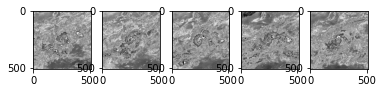

In [0]:
# Let's look at some sample images
# Warning: this may take a while initially and is prone to crashing. Execute
# at your own risk.

plt.figure(figsize=(512,512))
print("Sample data:")
fig, ax = plt.subplots(1,5)
for i in range(5):
  path = typhoons_df.iloc[i,11] + ".jpg"
  path = os.path.join(image_folder_path, path)
  img = plt.imread(path)
  ax[i].imshow(img, cmap='gray')
plt.show()

#### Problem: Binning labels
Note that the dataset does not come with T-numbers as a column. This means we would have to bin them by ourselves.

The ranges of values for pressures is 890-1016hPa and winds 0-125kt. While there _are_ tables that convert T-numbers into (predicted) pressure/wind values, because not every agency has the resources to fly an aircraft into the TC to measure them exactly, converting them the other way around is not easy. The data we have do not fit very well with the table, which is shown below for reference:

T-number|Winds(kt)|Pressure(hPa)
---|---|---|
1.0|25|N/A
1.5|25|N/A
2.0|30|1000
2.5|35|997
3.0|45|991
3.5|55|984
4.0|65|976
4.5|77|966
5.0|90|954
5.5|102|941
6.0|115|927
6.5|127|914
7.0|140|898
7.5|155|870
8.0|170|858

This leads to a couple problems:
* While T8.0 (at least according to the table) is very rare (technically the strongest two typhoons ever recorded are T7.5 as they were ~155kt and 870hPa), **we do not have any T7.5s in the dataset at all.**
* The table is defective in nature. **There are no pressure values for T1.0 and T1.5 and they have identical wind speed values.**
  * For pressure: This has to do with actual TCs having inconsitent central pressures when they are still weak. Once they reach T2.0/T2.5, they follow the pattern neatly.
  * For winds: It is speculated that the ambiguous T1.5 is created as a class, in order to show "a T1.0 TC has developed a bit, but not enough to reach T2.0 and plus".
* The max value of winds in the dataset is capped at 125kt which is quite miserable. This means **binning by winds would not bring us anywhere**, because everything since T6.5 would then be unavailable. 
  * Note about this issue: One of the said "strongest typhoons" literally happened between 2009 and 2019 (201330 "Haiyan"), and the website says its max winds are 125kt. They must be very cautious about numbers, even though min pressure is given as 895hPa, which is normal.

> For extra details why the above speculations hold and where does the reference table even come from, please consult resources about the Dvorak Technique itself.



Number of images per bin, grouped by wind speeds: [3397.    0.    0. 1677. 1048.  790. 1036.  645.  519.  161.   44.    0.
    0.    0.    0.]
Number of images per bin, grouped by wind speeds: [  32.  144.  144.  442.  438.  837.  867. 1690. 3108. 1615.]
Left: binned by winds, right: binned by pressure (neglect useless first plot below)


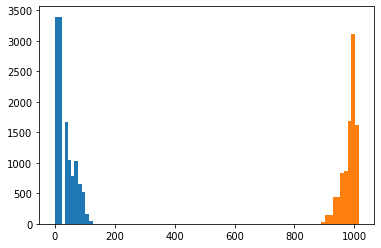

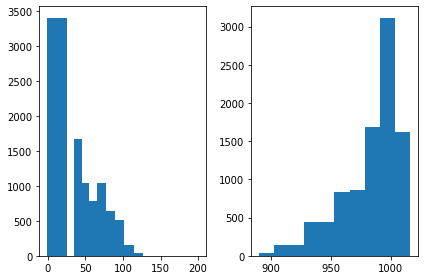

In [0]:
# Demonstation of the binning problem
def demo_bin():
  winds_col = typhoons_df["wind"].to_numpy()
  bins_wind = [-1, 25, 30, 35, 45, 55, 65, 77, 90, 102,115,127,140,155,170,200] #-1 to 25 for T1.0; 170-200 for T8.0
  hpa_col = typhoons_df["pressure"].to_numpy()
  bins_hpa = [2000, 1000, 997, 991, 984, 976, 966, 954, 941, 927, 914, 898, 870, 800].reverse()

  count, _, _ = plt.hist(winds_col, bins=bins_wind)
  print("Number of images per bin, grouped by wind speeds:", count)
  count, _, _ = plt.hist(hpa_col, bins=bins_hpa)
  print("Number of images per bin, grouped by wind speeds:", count)

  print("Left: binned by winds, right: binned by pressure (neglect useless first plot below)")
  fig, ax = plt.subplots(1,2, tight_layout=True)
  ax[0].hist(winds_col, bins=bins_wind)
  ax[1].hist(hpa_col, bins=bins_hpa)

  plt.show()
  
demo_bin()

As a result, binning has to be performed slightly differently. The table above would not be strictly followed, but a few classes would merge into one. We would bin things like this:

Actual Bin|T-number|Pressure (min. threshold)
---|---|---
1|1.0-1.5|(none)
2|2.0|1000
3|2.5|997
4|3.0|991
5|3.5|984
6|4.0|976
7|4.5|966
8|5.0|954
9|5.5|941
10|6.0|927
11|6.5|914
12|7.0-8.0|898

Altogether 12 classes. Example: Pressure = 987hPa -> bin #4 (because 987 < 991 but not < 984).

Number of images per bin, grouped by wind speeds: [  32.  144.  144.  442.  438.  837.  867. 1690. 3108. 1615.]


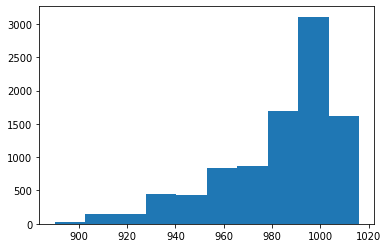

In [0]:
def demo_new_bin():
  hpa_col = typhoons_df["pressure"].to_numpy()
  bins_hpa = [2000, 1000, 997, 991, 984, 976, 966, 954, 941, 927, 914, 898, 800].reverse()
  count, _, _ = plt.hist(hpa_col, bins=bins_hpa)
  print("Number of images per bin, grouped by wind speeds:", count)

demo_new_bin()  #visualize

#### Observations
There are some observations we made about the dataset.
* The images do not zoom closely to the TC and sometimes capture a nearby TC.
  * This is an issue with the data source.
  * We would bear with it for now and observe what is going to happen.
* There is a very obvious surplus of images of weaker TCs.
  * The weakest class has 1615 images, but the strongest 32 only.
  * We would bear with it for now and observe what is going to happen.
  * Potential solutions are: **(To be finalized)**
    * rotate some images to make up for the numbers, but the images would be similar
    * go further back and obtain images from before 2009, until there aren't even such satellite images available
    * for these stronger TCs, we include satellite images taken every (for example) 3 hours instead of 6, thereby getting more (but similar) images
    * check other sources for images, but the images would have different dimensions/zooming levels or may require other preprocessing

## Interim Prototype

### [Interim Prototype] Preprocessing

This part is rather straightforward. Based on the criteria stated above, we drop unnecessary columns and bin the pressure values into labels (just using numbers 1-12 should be ok). Next the dataset is separated into train, dev and test sets. After that each set gets its own PyTorch DataLoader pipeline.

In [0]:
# Import 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [0]:
""" Preprocessing """
# Remove unnecessary columns
dataset = typhoons_df.drop(["id", "name", "year", "month", "day", "hour", "lat", "long", "wind", "class", "chart"], axis=1)

# Binning
bins = [-float('inf'), 898, 914, 927, 941, 954, 966, 976, 984, 991, 997, 1000, float('inf')]
labels = [0,1,2,3,4,5,6,7,8,9,10,11]
dataset['labels'] = pd.cut(x=dataset['pressure'], bins=bins, labels=labels)
labels_size = len(labels)
dataset = dataset.drop(['pressure'], axis=1)

# Separate into train, dev and test sets
dataset = shuffle(dataset)
train_set_ratio = 0.8
dev_set_ratio = 0.1
# pls add train-dev set similarly when needed :o

train_set, test_set = train_test_split(dataset, test_size = 1 - train_set_ratio)
test_set, dev_set = train_test_split(test_set, test_size = dev_set_ratio/(1-train_set_ratio))

print("train set:")
train_set.info()
print("dev set:")
dev_set.info()
print("test set:")
test_set.info()


train set:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 2663 to 185
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   img     7453 non-null   object  
 1   labels  7453 non-null   category
dtypes: category(1), object(1)
memory usage: 124.1+ KB
dev set:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 933 entries, 5915 to 675
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   img     933 non-null    object  
 1   labels  933 non-null    category
dtypes: category(1), object(1)
memory usage: 15.9+ KB
test set:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 931 entries, 2920 to 3021
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   img     931 non-null    object  
 1   labels  931 non-null    category
dtypes: category(1), object(1)
memory usage: 15.9+ KB


In [0]:
# Import pytorch and packages gonna use
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image

In [0]:
""" Custom PyTorch Dataset """
class TyDataset(Dataset):
  def __init__(self, df, is_pretrain=False):
    self.is_pretrain = is_pretrain
    self.image_paths = df['img']
    self.label_df = df['labels']
    self.transform = transforms.Compose([
      transforms.Resize(256),      #This is for pre-trained model use
      transforms.CenterCrop(224),  
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ]) if is_pretrain else transforms.ToTensor()
  
  def __len__(self):
    return len(self.image_paths)
  
  def __getitem__(self, idx):
    img_path = self.image_paths.iloc[idx] + ".jpg"
    img_path = os.path.join(image_folder_path, img_path)
    img = Image.open(img_path).convert('RGB') if self.is_pretrain else Image.open(img_path)
    label = self.label_df.iloc[idx]
    image = self.transform(img)
    return image, label

### [Interim Prototype] Building and Training a Model - Take 1: Pre-trained Net

After the preprocessing is complete, a model is developed as baseline.

Firstly we try to use a pre-trained CNN "densenet161" and see how it performs with our data.

For loss function we chose cross entropy loss and optimizer is Adam.

In [0]:
""" Creating DataLoader instances """
# DataLoader for training set
train_batch_size = batch_size
train_ds = TyDataset(train_set, is_pretrain=True)
train_loader = DataLoader(train_ds, batch_size = train_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Training set size (after DataLoader processing):", len(train_ds))

# DataLoader for dev set
dev_batch_size = batch_size
dev_ds = TyDataset(dev_set, is_pretrain=True)
dev_loader = DataLoader(dev_ds, batch_size = dev_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Dev set size (after DataLoader processing):", len(dev_ds))

# DataLoader for test set
test_batch_size = batch_size
test_ds = TyDataset(test_set, is_pretrain=True)
test_loader = DataLoader(test_ds, batch_size = test_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Training set size (after DataLoader processing):", len(test_ds))

Training set size (after DataLoader processing): 7453
Dev set size (after DataLoader processing): 933
Training set size (after DataLoader processing): 931


In [0]:
# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)
if not torch.cuda.is_available():
  print("Suggest you use GPU")

Device: cuda


In [0]:
""" Pre-trained CNN Model """
import torchvision.models as models

class interim_prototype_take1(nn.Module):
  def __init__(self):
    super(interim_prototype_take1, self).__init__()
    ## Define layers
    # Input shape: (Batch size, 1, 512, 512)
    # Convolution layer(s)
    self.conv = self.pretrained_model()
    # FC layer(s)
    self.fc = nn.Sequential(
          nn.Linear(1000, 512), # 1000 is the default output size in densenet
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(512, 12)
        )
  
  def pretrained_model(self):
    model = models.densenet161(pretrained=True) 
    for param in model.parameters():
      param.requires_grad = False
    return model

  def forward(self, x):
    x = self.conv(x)
    x = self.fc(x)
    return x

# construct and pass to device
interim_model = interim_prototype_take1()
interim_model = interim_model.to(device)
# print("Interim prototype model structure: ")
# print(interim_model) 

In [0]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(interim_model.parameters(), lr=learning_rate)

Now with the preparation complete, the following performs the training process.

In [0]:
# Function to train one epoch, adopted from Module 3 materials
def train_one_epoch(model, device, criterion, optimizer, dataloader):
  model.train()
  epoch_loss = 0.0
  correct_preds, total_preds = 0, 0

  for i, (images, labels) in enumerate(dataloader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model.forward(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, preds = torch.max(outputs.data, 1)
    correct_preds += (preds == labels).sum().item()
    total_preds += labels.size(0)
    epoch_loss += loss.item()

    if (i%20 == 0):
      print("# Batches Processed: ",i,"/",len(dataloader))
  
  log_dict = {}
  log_dict['loss'] = epoch_loss
  log_dict['acc'] = (100 * correct_preds/total_preds) #Fixed acc calculation here
  return log_dict

In [0]:
# Function for evaluation, modified from Module 3 materials
def eval_one_epoch(model, device, criterion, dataloader):
  model.eval()
  epoch_loss = 0.0
  correct_preds, total_preds = 0.0, 0.0

  for i, (images, labels) in enumerate(dataloader):
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
      outputs = model(images)
    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs.data, 1)
    correct_preds += (preds == labels).sum().item()
    total_preds += labels.size(0)
    epoch_loss += loss.item()
  
  log_dict = {}
  log_dict['loss'] = epoch_loss
  log_dict['acc'] = (100 * correct_preds/total_preds) #fixed
  return log_dict

In [0]:
# Main training loop ahead
from time import time

all_train_acc, all_dev_acc = [], []
begin_time = time()
for epoch in range(n_epochs):
  print("Running epoch ",epoch,"/",n_epochs,":")
  print("====================")

  log_dict = train_one_epoch(interim_model, device=device, criterion=criterion, optimizer=optimizer, dataloader=train_loader)
  train_loss = log_dict['loss'] / len(train_loader)
  train_acc = log_dict['acc']
  all_train_acc.append(train_acc)

  log_dict = eval_one_epoch(interim_model, device=device, criterion=criterion, dataloader=dev_loader)
  dev_loss = log_dict['loss'] / len(dev_loader)
  dev_acc = log_dict['acc']
  all_dev_acc.append(dev_acc)

  finish_time = time()
  print("Time: ", finish_time-begin_time)
  print("----Training----")
  print("Loss: ", train_loss)
  print("Acc: ", train_acc)
  print("----Dev----")
  print("Loss: ", dev_loss)
  print("Acc: ", dev_acc)
  print("====================")

Running epoch  0 / 20 :
# Batches Processed:  0 / 232
# Batches Processed:  20 / 232
# Batches Processed:  40 / 232
# Batches Processed:  60 / 232
# Batches Processed:  80 / 232
# Batches Processed:  100 / 232
# Batches Processed:  120 / 232
# Batches Processed:  140 / 232
# Batches Processed:  160 / 232
# Batches Processed:  180 / 232
# Batches Processed:  200 / 232
# Batches Processed:  220 / 232
Time:  58.52582931518555
----Training----
Loss:  1.8902460742613365
Acc:  29.72790948275862
----Dev----
Loss:  1.7181422217138882
Acc:  33.081896551724135
Running epoch  1 / 20 :
# Batches Processed:  0 / 232
# Batches Processed:  20 / 232
# Batches Processed:  40 / 232
# Batches Processed:  60 / 232
# Batches Processed:  80 / 232
# Batches Processed:  100 / 232
# Batches Processed:  120 / 232
# Batches Processed:  140 / 232
# Batches Processed:  160 / 232
# Batches Processed:  180 / 232
# Batches Processed:  200 / 232
# Batches Processed:  220 / 232
Time:  117.29482889175415
----Training---

In [0]:
# Model evaluation: benchmarking with test
log_dict = eval_one_epoch(interim_model, device, criterion, dataloader=test_loader)
test_loss = log_dict['loss']
test_acc = log_dict['acc']
print("Test results:")
print("====================")
print("Loss: ", test_loss)
print("Acc: ", test_acc)
print("Try harder!")
print("====================")

Test results:
Loss:  103.57962131500244
Acc:  28.879310344827587
Try harder!


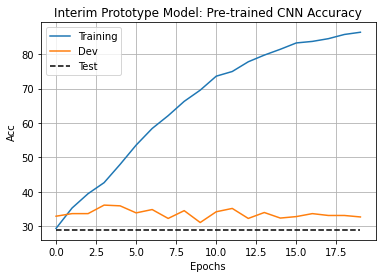

In [0]:
# Some visualization code
fig, ax = plt.subplots()
plt.title("Interim Prototype Model: Pre-trained CNN Accuracy")
ax.plot(all_train_acc, label="Training")
ax.plot(all_dev_acc, label="Dev")
plt.hlines(test_acc, xmin=0, xmax=n_epochs-1, label="Test", linestyles='dashed')

plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc='upper left')
plt.show()

The following are obtained from the first successful (i.e. no runtime error) test run of the said model:

||Training|Dev|Test|
---|---|---|---
Acc:| 0.001 | 0.002 | 0.0018

Running time: 1745s = ca. 29 minutes

![Image: performance plot](https://drive.google.com/uc?id=1bRPjaNC97slYTRQZ6wNJHt5GdhO9YaMV)

The performance is not satisfactory at all. We assumed that the pre-trained model is trained on RGB images of other uses/sources, therefore it does not adapt well, if at all, to this new situation. 

However, after fixing an issue with accuracy calculation, the performance improved greatly, except we observe overfitting:

||Training|Dev|Test|
---|---|---|---
Acc:| 85.829 | 31.034 | 30.388

Running time: 2181s = ca. 36 minutes

![alt text](https://drive.google.com/uc?id=14tvApO6KbhSAcDUdzYUD7ZOvtQMQw-Qx)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Batches evaluated:  0 / 232
# Batches evaluated:  20 / 232
# Batches evaluated:  40 / 232
# Batches evaluated:  60 / 232
# Batches evaluated:  80 / 232
# Batches evaluated:  100 / 232
# Batches evaluated:  120 / 232
# Batches evaluated:  140 / 232
# Batches evaluated:  160 / 232
# Batches evaluated:  180 / 232
# Batches evaluated:  200 / 232
# Batches evaluated:  220 / 232
Shapes: torch.Size([7424]) ; torch.Size([7424])


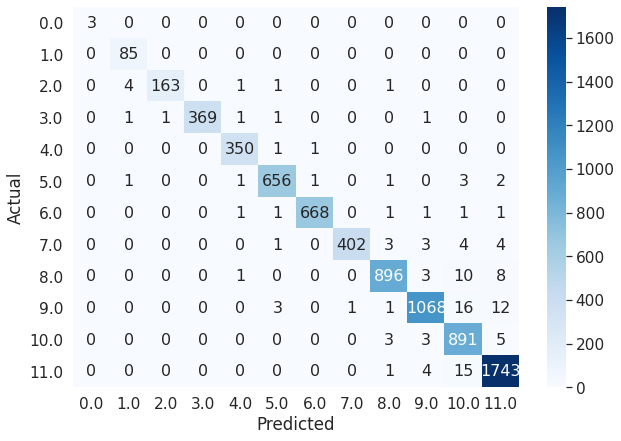

In [0]:
""" Visualization: Confusion Matrix with training data """
import seaborn as sn
from sklearn.metrics import confusion_matrix

def get_all_preds(model, loader, device):
  all_preds = []
  all_labels = []
  with torch.no_grad():
    for i, (images, labels) in enumerate(loader):
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      preds = torch.argmax(output.data, 1)
      all_preds.extend(preds) #torch.cat((all_preds, preds), dim=0)
      all_labels.extend(labels)# = torch.cat((all_labels, labels), dim=0)
      if (i%20 == 0):
        print("# Batches evaluated: ",i,"/",len(loader))
  return all_preds, all_labels

train_preds, train_truth = get_all_preds(interim_model, train_loader, device)
train_preds, train_truth = torch.FloatTensor(train_preds), torch.FloatTensor(train_truth)
print("Shapes:",train_preds.size(),";",train_truth.size())
data = confusion_matrix(train_truth, train_preds)
df_cm = pd.DataFrame(data, columns=np.unique(train_truth), index = np.unique(train_truth))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')

# Batches evaluated:  0 / 29
# Batches evaluated:  20 / 29
Shapes: torch.Size([928]) ; torch.Size([928])


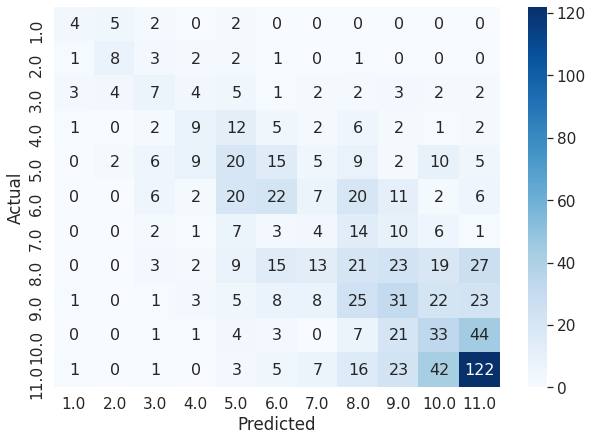

In [0]:
""" Visualization: Confusion Matrix with Test Set"""
test_preds, test_truth = get_all_preds(interim_model, test_loader, device)
test_preds, test_truth = torch.FloatTensor(test_preds), torch.FloatTensor(test_truth)
print("Shapes:",test_preds.size(),";",test_truth.size())
data = confusion_matrix(test_truth, test_preds)
df_cm = pd.DataFrame(data, columns=np.unique(test_truth), index = np.unique(test_truth))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')

### [Interim Prototype] Building and Training a Model - Take 2: Custom CNN

This time, we construct our own model from scratch. The structure is as follows:
* Conv2D with 16 filters and kernel size 3, followed by a ReLU
* Conv2D with 16 filters and kernel size 3, followed by a ReLU, average pooling (kernel size 2) and dropout (0.2)
* Conv2D with 16 filters and kernel size 3, followed by a ReLU, average pooling (kernel size 2) and dropout (0.2)
* Conv2D with 16 filters and kernel size 3, followed by a ReLU, average pooling (kernel size 2) and dropout (0.2)
* Flattening and Linear layer (65536 neurons -> 4096) with ReLU and dropout (0.2)
* Linear (4096 -> 1024) with ReLU
* Linear (1024 -> 32) with Sigmoid

For optimizer and loss function choices, we stick to Adam and Cross Entropy respectively as before.

In [0]:
""" Reused code """
# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)
if not torch.cuda.is_available():
  print("Suggest you use GPU")

Device: cuda


In [0]:
# DataLoader for training set
train_batch_size = batch_size
train_ds = TyDataset(train_set)
train_loader = DataLoader(train_ds, batch_size = train_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Training set size (after DataLoader processing):", len(train_ds))

# DataLoader for dev set
dev_batch_size = batch_size
dev_ds = TyDataset(dev_set)
dev_loader = DataLoader(dev_ds, batch_size = dev_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Dev set size (after DataLoader processing):", len(dev_ds))

# DataLoader for test set
test_batch_size = batch_size
test_ds = TyDataset(test_set)
test_loader = DataLoader(test_ds, batch_size = test_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Training set size (after DataLoader processing):", len(test_ds))

Training set size (after DataLoader processing): 7453
Dev set size (after DataLoader processing): 933
Training set size (after DataLoader processing): 931


In [0]:
""" New Model """

class interim_prototype_take2(nn.Module):
  def __init__(self):
    super(interim_prototype_take2, self).__init__()
    # CNN Model layers
    # Input shape: Batch size B, 1 channel, 512, 512
    
    # conv. layers
    self.conv = nn.Sequential(
        # After 1st conv: (B, 1, 512, 512) -> (B, 16, 512, 512)
        nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        # After 2nd conv: (B, 16, 512, 512) -> (B, 16, 512, 512)
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        # After AvgPool2d: (B, 16, 512, 512) -> (B, 16, 256, 256)
        nn.AvgPool2d(kernel_size=2),  #stride = 1?
        nn.Dropout(0.20),
        # After 3rd conv: (B, 16, 256, 256) -> (B, 16, 256, 256)
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        # After AvgPool2d: (B, 16, 256, 256) -> (B, 16, 128, 128)
        nn.AvgPool2d(kernel_size=2),
        nn.Dropout(0.20),
        # After 4th conv: (B, 16, 128, 128) -> (B, 16, 128, 128)
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        # After AvgPool2d: (B, 16, 128, 128) -> (B, 16, 64, 64)
        nn.AvgPool2d(kernel_size=2),
        nn.Dropout(0.20),
    )

    # FC layers
    self.fc = nn.Sequential(
        # After flattening: (B, 16, 64, 64) -> (B, 16*64*64) (65,536 neurons)
        nn.Flatten(),
        nn.Linear(16*64*64,1024),
        nn.ReLU(True),
        nn.Dropout(0.20),
        nn.Linear(1024, 12), #fix output shape to (B, B)
        #nn.Sigmoid(), #potentially problematic
    )
  
  def forward(self,x):
    x = self.conv(x)
    x = self.fc(x)
    return x

interim_model_1 = interim_prototype_take2()
interim_model_1 = interim_model.to(device)
print("New model structure:")
print(interim_model)

New model structure:
interim_prototype_take2(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): ReLU(inplace=True)
    (12): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (13): Dropout(p=0.2, inplace=False)
  )
  (fc): Sequential(
    (0): Flatten()
    (1): Linear(in_features=65536, out_features=1024, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Lin

In [0]:
""" Reused """
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(interim_model.parameters(), lr=learning_rate)

In [0]:
""" Slightly adjusted train_one_epoch code"""
def train_one_epoch(model, device, criterion, optimizer, dataloader):
  model.train()
  epoch_loss = 0.0
  correct_preds, total_preds = 0.0, 0.0

  for i, (images, labels) in enumerate(dataloader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model.forward(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, preds = torch.max(outputs.data, 1)
    correct_preds += (preds == labels).sum().item()
    total_preds += labels.size(0)
    epoch_loss += loss.item()
    if (i%20 == 0):
      print("# Batches Processed: ",i,"/",len(dataloader))
  
  log_dict = {}
  log_dict['loss'] = epoch_loss
  log_dict['acc'] = (100 * correct_preds/total_preds)
  return log_dict

  """ Do execute the cell containing eval_one_epoch again """

In [0]:
""" Reused: Training loop """
from time import time

all_train_acc, all_dev_acc = [], []
begin_time = time()
for epoch in range(n_epochs):
  print("Running epoch ",epoch,"/",n_epochs,":")
  print("====================")

  log_dict = train_one_epoch(interim_model_1, device=device, criterion=criterion, optimizer=optimizer, dataloader=train_loader)
  train_loss = log_dict['loss'] / len(train_loader)
  train_acc = log_dict['acc']
  all_train_acc.append(train_acc)

  log_dict = eval_one_epoch(interim_model_1, device=device, criterion=criterion, dataloader=dev_loader)
  dev_loss = log_dict['loss'] / len(dev_loader)
  dev_acc = log_dict['acc']
  all_dev_acc.append(dev_acc)

  finish_time = time()
  print("Time: ", finish_time-begin_time)
  print("----Training----")
  print("Loss: ", train_loss)
  print("Acc: ", train_acc)
  print("----Dev----")
  print("Loss: ", dev_loss)
  print("Acc: ", dev_acc)
  print("====================")

Running epoch  0 / 20 :
# Batches Processed:  0 / 232
# Batches Processed:  20 / 232
# Batches Processed:  40 / 232
# Batches Processed:  60 / 232
# Batches Processed:  80 / 232
# Batches Processed:  100 / 232
# Batches Processed:  120 / 232
# Batches Processed:  140 / 232
# Batches Processed:  160 / 232
# Batches Processed:  180 / 232
# Batches Processed:  200 / 232
# Batches Processed:  220 / 232
Time:  49.13365864753723
----Training----
Loss:  2.018684422147685
Acc:  25.915948275862068
----Dev----
Loss:  1.8542564202999245
Acc:  31.896551724137932
Running epoch  1 / 20 :
# Batches Processed:  0 / 232
# Batches Processed:  20 / 232
# Batches Processed:  40 / 232
# Batches Processed:  60 / 232
# Batches Processed:  80 / 232
# Batches Processed:  100 / 232
# Batches Processed:  120 / 232
# Batches Processed:  140 / 232
# Batches Processed:  160 / 232
# Batches Processed:  180 / 232
# Batches Processed:  200 / 232
# Batches Processed:  220 / 232
Time:  97.99200296401978
----Training----

In [0]:
""" Reused: Evaluation """
log_dict = eval_one_epoch(interim_model_1, device, criterion, dataloader=test_loader)
test_loss = log_dict['loss']
test_acc = log_dict['acc']
print("Test results:")
print("====================")
print("Loss: ", test_loss)
print("Acc: ", test_acc)
print("Is this better than before?")
print("====================")

Test results:
Loss:  177.38295793533325
Acc:  29.95689655172414
Is this better than before?


The following are obtained from a run on 18th April, without the sigmoid:

||Training|Dev|Test|
---|---|---|---
Acc:| 99.232 | 29.418 | 26.616

Running time: 1630s ~= 27 minutes. Below are visualization of the model's performance.

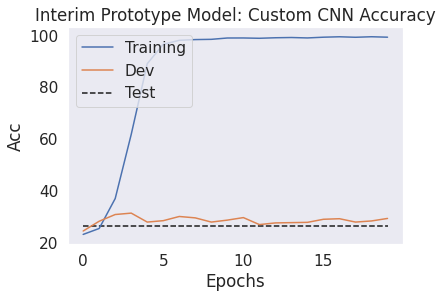

In [0]:
""" Visualization: Accuracy over epoch graph """
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
plt.title("Interim Prototype Model: Custom CNN Accuracy")
ax.plot(all_train_acc, label="Training")
ax.plot(all_dev_acc, label="Dev")
plt.hlines(test_acc, xmin=0, xmax=n_epochs-1, label="Test", linestyles='dashed')

plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc='upper left')
plt.show()

# Batches evaluated:  0 / 232
# Batches evaluated:  20 / 232
# Batches evaluated:  40 / 232
# Batches evaluated:  60 / 232
# Batches evaluated:  80 / 232
# Batches evaluated:  100 / 232
# Batches evaluated:  120 / 232
# Batches evaluated:  140 / 232
# Batches evaluated:  160 / 232
# Batches evaluated:  180 / 232
# Batches evaluated:  200 / 232
# Batches evaluated:  220 / 232
Shapes: torch.Size([7424]) ; torch.Size([7424])


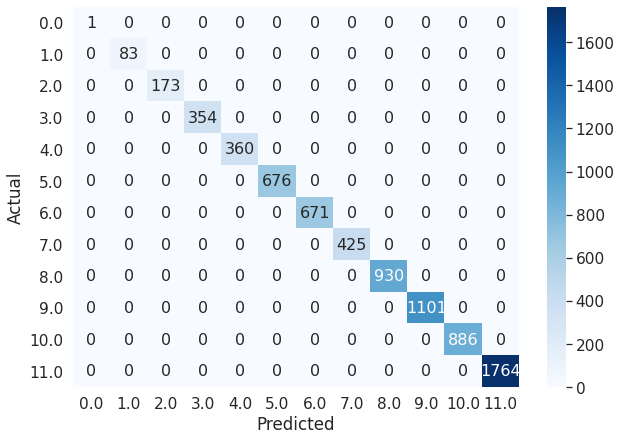

In [0]:
""" Visualization: Confusion Matrix with training data """
# Adapted from https://www.kaggle.com/agungor2/various-confusion-matrix-plots
import seaborn as sn
from sklearn.metrics import confusion_matrix

def get_all_preds(model, loader, device):
  all_preds = []
  all_labels = []
  with torch.no_grad():
    for i, (images, labels) in enumerate(loader):
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      preds = torch.argmax(output.data, 1)
      all_preds.extend(preds) #torch.cat((all_preds, preds), dim=0)
      all_labels.extend(labels)# = torch.cat((all_labels, labels), dim=0)
      if (i%20 == 0):
        print("# Batches evaluated: ",i,"/",len(loader))
  return all_preds, all_labels

train_preds, train_truth = get_all_preds(interim_model_1, train_loader, device)
train_preds, train_truth = torch.FloatTensor(train_preds), torch.FloatTensor(train_truth)
print("Shapes:",train_preds.size(),";",train_truth.size())
data = confusion_matrix(train_truth, train_preds)
df_cm = pd.DataFrame(data, columns=np.unique(train_truth), index = np.unique(train_truth))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')

# Batches evaluated:  0 / 29
# Batches evaluated:  20 / 29
Shapes: torch.Size([928]) ; torch.Size([928])


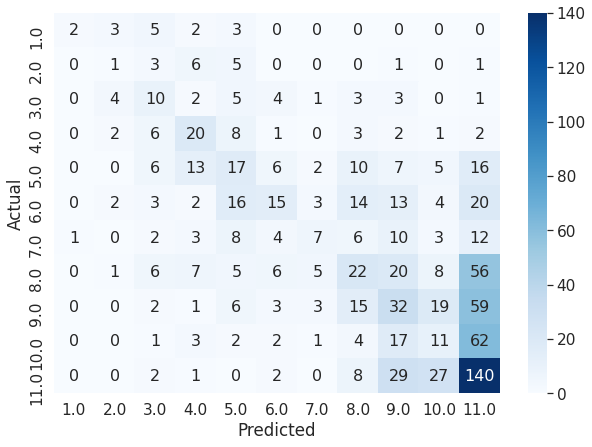

In [0]:
""" Visualization: Confusion Matrix with Test Set"""
test_preds, test_truth = get_all_preds(interim_model_1, test_loader, device)
test_preds, test_truth = torch.FloatTensor(test_preds), torch.FloatTensor(test_truth)
print("Shapes:",test_preds.size(),";",test_truth.size())
data = confusion_matrix(test_truth, test_preds)
df_cm = pd.DataFrame(data, columns=np.unique(test_truth), index = np.unique(test_truth))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')

### [Interim Prototype] Conclusions about the two models

Both models have shown overfitting to the training data and yielded similar results when they were evaluated with the test set. We hypothesize that they have overfitted and failed to extract the key features from the images, leading to ridiculous results.

There are many ways that we can improve the outcome. In the upcoming week (since 20 April), we would soon be granted access to Prof. Kitamoto's dataset, which may provide useful insights; in addition thereto, visualizing the convolution network weights, introducing cross validation and modifying model architecture (esp. its depth, dropout rate and choice of activation functions) are also viable ways to improve.

### Demo of current model

Lets give a typhoon picture to our current model to see how the models perform!


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


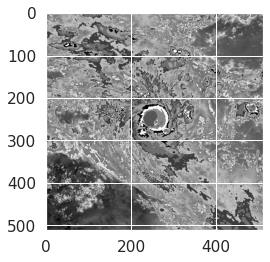

In [0]:
from PIL import Image
import requests
from io import BytesIO
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


response = requests.get('http://agora.ex.nii.ac.jp/digital-typhoon/wsp/by-name/201822/bd/512x512/HMW818032312.201822.jpg')
img = Image.open(BytesIO(response.content))
imgplot = plt.imshow(img, cmap='gray')
plt.show()

In [0]:
transform = transforms.Compose([
    transforms.ToTensor()
    ]
)
t = transform(img).unsqueeze(0).cuda()
with torch.no_grad():
  outputs = interim_model_1(t)
  _, predicted = torch.max(outputs.data, 1)
  print(predicted)
  

tensor([11], device='cuda:0')


In [0]:
transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),  
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

t = transform(img.convert('RGB')).unsqueeze(0).cuda()

with torch.no_grad():
  outputs = interim_model(t)
  _, predicted = torch.max(outputs.data, 1)
  print(predicted)

tensor([1], device='cuda:0')
